## Categorizing Clothing with CNN
In this project we explore the use of convolutional neural nets for image classification; our dataset is a collection of 60,000 images of 10 different types of clothing / accessories. The goal of this notebook is to explore the initial dataset, fit a sequential CNN using keras, understand model parameters by testing their effect on model results, and finally, to evaluate the model's predictions and investigate where it falls short. This notebook is 6-part:

1. Data Exploration
2. Convolutional Neural Nets: Exploration
3. Convolutional Neural Nets: Optimization
4. Visualizing Filters and Feature Maps
5. Prediction Analysis
6. Conclusion

The comments in this notebook serve to orient the reader around my thought process at each step. For a more in-depth explanation of how convolutional neural nets work, see my blog post [here](https://christinejiang.net/posts/convolutional-neural-nets).

### 1. Data Exploration & Preprocessing
Here we import the dataset, do some light exploration to understand its attributes, and process the data for feeding into the model. Cell 2 displays a random sample of 3 images from each category from our training data. Note that there is a uniform distribution across the 10 categories, and that all images are centered and feature objects of relatively the same size. We will address this point in Section 3, using data augmentation to introduce more variety and hopefully greater ability to generalize to unseen data.

Keras - the neural network library we will be using to construct our model - requires input vectors to have an extra dimension which correspond to their channels. Working with grayscale data means our inputs only have one channel, so we reshape our train and test images to 28 x 28 x 1 3D matrices. Lastly, we create a validation dataset to evaluate our model's accuracy and watch for over/under-fitting during training.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from collections import Counter
import time
import random

from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.datasets import mnist, fashion_mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

np.random.seed(2)
plt.style.use('fivethirtyeight')

Using TensorFlow backend.


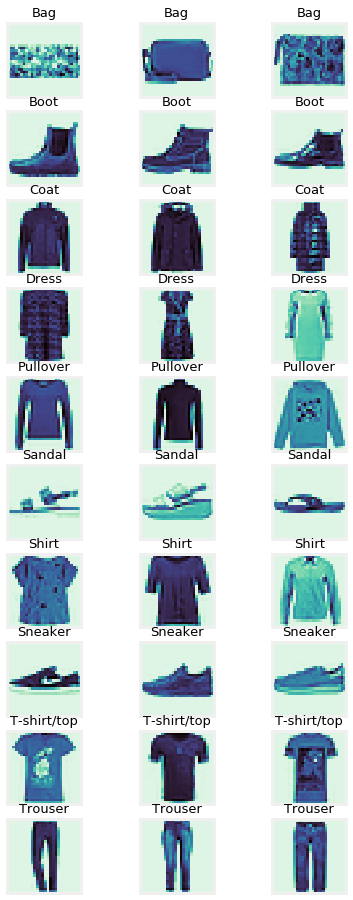

In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

categories = {0: 'T-shirt/top',
             1: 'Trouser',
             2: 'Pullover',
             3: 'Dress',
             4: 'Coat',
             5: 'Sandal',
             6: 'Shirt',
             7: 'Sneaker',
             8: 'Bag',
             9: 'Boot'}

#plot random sample of each category
test = list(zip(x_train, [categories[x] for x in y_train]))
test_df = pd.DataFrame(test)

function = lambda obj: obj.loc[np.random.choice(obj.index, 3, False)]
grouped = test_df.groupby(1).apply(function)

fig, axes = plt.subplots(10, 3, figsize=(6,16))
axes = axes.flatten()
for i, image in enumerate(grouped[0]):
    axes[i].imshow(image, cmap='mako_r')
    axes[i].set_title(grouped[1][i], size=13)
    axes[i].set_xticks([])
    axes[i].set_yticks([])

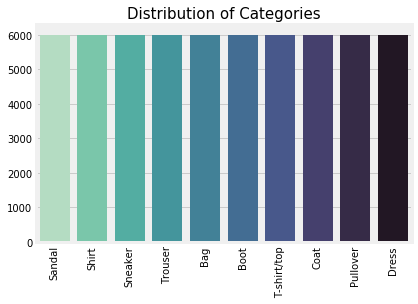

In [3]:
#plot distribution of categories in training set
category_series = pd.Series(y_train).map(categories)
category_counts = category_series.value_counts()
sns.barplot(category_counts.index, category_counts, palette='mako_r')
ticks=plt.xticks(rotation='vertical')
title=plt.title('Distribution of Categories',size=15)

In [4]:
#check for nulls
print(f'Nulls in x_train: {np.isnan(x_train).sum()}')
print(f'Nulls in x_test: {np.isnan(x_test).sum()}')
print(f'Nulls in y_train: {np.isnan(y_train).sum()}')
print(f'Nulls in y_test: {np.isnan(y_test).sum()}')

Nulls in x_train: 0
Nulls in x_test: 0
Nulls in y_train: 0
Nulls in y_test: 0


In [5]:
#scaling to ease computational burden of model; CNN converges faster on [0,1] data than on [0,255]
#note: scaling does not change the way the image renders
x_train_scaled = x_train/255
x_test_scaled = x_test/255

#convert to float32, float64 uses twice as much memory
x_train_scaled_32 = x_train_scaled.astype('float32')
x_test_scaled_32 = x_test_scaled.astype('float32')

#reshape to 4d array with expected input shape of (batch, rows, columns, channels) for keras
#since images are grayscale (1 channel), last dimension is 1
x_train_scaled_shape = x_train_scaled_32.reshape(x_train_scaled_32.shape[0], 28, 28, 1)
x_test_scaled_shape = x_test_scaled_32.reshape(x_test_scaled_32.shape[0], 28, 28, 1)

#convert labels to one-hot-encoded arrays
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

#create validation set
#because we have uniform distribution of y labels, no need to stratify
x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(x_train_scaled_shape, y_train_cat, test_size=0.2, random_state=2)

### 2. Convolutional Neural Nets: Exploration
This section explores the effect of tuning CNN parameters, focusing on two parameters in particular - 1) the number of filters in a convolutional layer (I will refer to this as the "filter value") and 2) kernel size. The create_params function creates a dictionary for every combination of these two parameters as indicated by the user; we then loop over this list of dictionaries to create a CNN for each set of parameters and store each model's results for further analysis. Note that for the sake of testing, we fit a simple model here, featuring just one convolutional layer and one dense layer. We will implement a more complex model focused on predictive accuracy in the next section.

In [36]:
def create_params(values_dict: dict) -> list:
    """Create list of dictionaries for every combination of kernel / filter values indicated"""
    (key1, val1), (key2, val2) = values_dict.items()
    return [{key1: x, key2: y} for x in val1 for y in val2]

class CNN:
    def __init__(self, params_dict):
        self.params = params_dict
        self.kernels = params_dict['kernels']
        self.filters = params_dict['filters']
        self.model = self.create_model()
        
    
    def create_model(self):
        '''Simple Sequential model using variations of kernel size and number of filters as indicated by the user'''
        kernels = self.kernels
        filters = self.filters
        model = Sequential([Conv2D(filters=filters, kernel_size=kernels, activation='relu',input_shape=x_train_scaled_shape.shape[1:]),
                            Flatten(),
                            Dense(10, activation='softmax')])
        return model
    

    def fit_model(self, model, epochs=3, batch_size=100):

        start_time = time.time()
        kernels = self.kernels
        filters = self.filters
        model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
        datagen = ImageDataGenerator(rotation_range=10,
                                zoom_range=0.1,
                                width_shift_range=0.1,
                                height_shift_range=0.1)
    
        model_output = model.fit_generator(datagen.flow(x_train_scaled_shape, y_train_cat, batch_size=batch_size), epochs=epochs,
                                 validation_data=(datagen.flow(x_test_scaled_shape, y_test_cat)), steps_per_epoch=x_train_scaled_shape.shape[0]/batch_size)
        end_time = time.time()
        model_time = end_time - start_time
        history = pd.DataFrame(model_output.history)
        history['epoch'] = list(range(1, epochs+1))
        history['model_time'] = model_time
        history['filters'] = filters
        history['kernel_size'] = str(kernels)
        return history

In [32]:
params_list

[{'kernels': (5, 5), 'filters': 5},
 {'kernels': (5, 5), 'filters': 10},
 {'kernels': (5, 5), 'filters': 30},
 {'kernels': (5, 5), 'filters': 60},
 {'kernels': (10, 10), 'filters': 5},
 {'kernels': (10, 10), 'filters': 10},
 {'kernels': (10, 10), 'filters': 30},
 {'kernels': (10, 10), 'filters': 60},
 {'kernels': (15, 15), 'filters': 5},
 {'kernels': (15, 15), 'filters': 10},
 {'kernels': (15, 15), 'filters': 30},
 {'kernels': (15, 15), 'filters': 60},
 {'kernels': (28, 28), 'filters': 5},
 {'kernels': (28, 28), 'filters': 10},
 {'kernels': (28, 28), 'filters': 30},
 {'kernels': (28, 28), 'filters': 60}]

In [37]:
testdict = {'kernels':[(5,5),(10,10),(15,15),(28,28)], 'filters':[5,10,30,60]}
params_list = create_params(testdict)

all_results = pd.DataFrame()
for param in params_list:
    cnn = CNN(param)
    model = cnn.create_model()
    model_results = cnn.fit_model(model, epochs=10, batch_size=100)
    all_results = all_results.append(model_results)

Epoch 1/10
600/600 [==============================] - 20s 33ms/step - loss: 0.8403 - accuracy: 0.6944 - val_loss: 0.8234 - val_accuracy: 0.7301
Epoch 2/10
600/600 [==============================] - 21s 35ms/step - loss: 0.6975 - accuracy: 0.7445 - val_loss: 0.2378 - val_accuracy: 0.7552
Epoch 3/10
600/600 [==============================] - 19s 32ms/step - loss: 0.6483 - accuracy: 0.7620 - val_loss: 1.1431 - val_accuracy: 0.7595
Epoch 4/10
600/600 [==============================] - 21s 35ms/step - loss: 0.6082 - accuracy: 0.7768 - val_loss: 0.7545 - val_accuracy: 0.7756
Epoch 5/10
600/600 [==============================] - 20s 33ms/step - loss: 0.5907 - accuracy: 0.7812 - val_loss: 0.6845 - val_accuracy: 0.7855
Epoch 6/10
600/600 [==============================] - 21s 35ms/step - loss: 0.5740 - accuracy: 0.7898 - val_loss: 0.5844 - val_accuracy: 0.7858
Epoch 7/10
600/600 [==============================] - 21s 34ms/step - loss: 0.5614 - accuracy: 0.7950 - val_loss: 0.5246 - val_accuracy:

Epoch 8/10
600/600 [==============================] - 20s 34ms/step - loss: 0.5199 - accuracy: 0.8084 - val_loss: 0.8214 - val_accuracy: 0.8058
Epoch 9/10
600/600 [==============================] - 21s 35ms/step - loss: 0.5127 - accuracy: 0.8122 - val_loss: 0.5786 - val_accuracy: 0.8064
Epoch 10/10
600/600 [==============================] - 22s 36ms/step - loss: 0.5157 - accuracy: 0.8130 - val_loss: 0.4379 - val_accuracy: 0.8111
Epoch 1/10
600/600 [==============================] - 26s 43ms/step - loss: 0.7243 - accuracy: 0.7338 - val_loss: 0.9249 - val_accuracy: 0.7637
Epoch 2/10
600/600 [==============================] - 26s 43ms/step - loss: 0.5698 - accuracy: 0.7898 - val_loss: 0.9612 - val_accuracy: 0.7932
Epoch 3/10
600/600 [==============================] - 24s 39ms/step - loss: 0.5259 - accuracy: 0.8048 - val_loss: 0.5434 - val_accuracy: 0.8066
Epoch 4/10
600/600 [==============================] - 24s 40ms/step - loss: 0.5082 - accuracy: 0.8122 - val_loss: 0.5886 - val_accuracy

Epoch 5/10
600/600 [==============================] - 27s 45ms/step - loss: 0.5020 - accuracy: 0.8131 - val_loss: 0.5431 - val_accuracy: 0.8124
Epoch 6/10
600/600 [==============================] - 27s 44ms/step - loss: 0.4887 - accuracy: 0.8174 - val_loss: 0.3813 - val_accuracy: 0.8199
Epoch 7/10
600/600 [==============================] - 27s 45ms/step - loss: 0.4819 - accuracy: 0.8181 - val_loss: 0.9448 - val_accuracy: 0.8179
Epoch 8/10
600/600 [==============================] - 27s 44ms/step - loss: 0.4702 - accuracy: 0.8245 - val_loss: 0.4146 - val_accuracy: 0.8152
Epoch 9/10
600/600 [==============================] - 26s 44ms/step - loss: 0.4683 - accuracy: 0.8273 - val_loss: 0.3193 - val_accuracy: 0.8232
Epoch 10/10
600/600 [==============================] - 26s 44ms/step - loss: 0.4599 - accuracy: 0.8292 - val_loss: 0.2501 - val_accuracy: 0.8243
Epoch 1/10
600/600 [==============================] - 14s 23ms/step - loss: 1.3593 - accuracy: 0.5184 - val_loss: 1.0404 - val_accuracy

In [33]:
all_results.head(10)

,val_loss,val_accuracy,loss,accuracy,epoch,model_time,filters,kernel_size
0,0.579017,0.7878,0.796976,0.712400,1,139.994302,5,"(5, 5)"
1,0.546647,0.7939,0.637927,0.766183,2,139.994302,5,"(5, 5)"
2,0.511948,0.8158,0.598933,0.781050,3,139.994302,5,"(5, 5)"
3,0.480403,0.8315,0.571883,0.793133,4,139.994302,5,"(5, 5)"
4,0.488348,0.8291,0.556595,0.798583,5,139.994302,5,"(5, 5)"
5,0.471747,0.8338,0.546035,0.800333,6,139.994302,5,"(5, 5)"
6,0.452468,0.8405,0.536643,0.806200,7,139.994302,5,"(5, 5)"
7,0.462981,0.8356,0.532282,0.807950,8,139.994302,5,"(5, 5)"
8,0.462585,0.8354,0.525910,0.809317,9,139.994302,5,"(5, 5)"
9,0.485482,0.8191,0.522005,0.810967,10,139.994302,5,"(5, 5)"



After training the models, we look at how the accuracy scores, losses, and model training times compare across filter values and kernel sizes. The lines in the line graphs represent the _average_ accuracy or loss across four CNN models with the indicated parameter, while the shaded regions in the graphs represent the 95% confidence intervals of this average value. For example, with the parameters we tested above, a filter value of 5 is used in four different models:
1. 5 filters, 5x5 kernel size
2. 5 filters, 10x10 kernel size
3. 5 filters, 15x15 kernel size
4. 5 filters, 28x28 kernel size 

The lavender-colored line in the top left graph then represents the average training accuracy across these four models _for our current training runs_ , while the shaded region represents the range in which, if we were to train and evaluate these models numerous times, would contain the true average model accuracy 95% of the time. 

From our pseudo-grid search, we glean the following:
- As expected, the accuracy and loss are improved with a higher number of filters - though as the number of epochs increases, the models with 60 filters perform only marginally better than those with 30.
- Model training time does increase with the number of filters, but not in a linear fashion - models with 5, 10, and 30 filters in the convolutional layer take a similar time to train (avg: 140 seconds), while the model with 60 filters takes longer (avg: 170 seconds) with greater variance. While this difference is not a significant inconvenience, it is useful to note that the 25% increase in model training time only yields a 0.7% increase in model accuracy - perhaps not a worthy trade-off for more complex models. 
- We also see a clear pattern with kernel size, as smaller kernel sizes yield greater accuracy / lower loss and are able to detect patterns over smaller receptive fields. 
- Interestingly, model training time does not change as we might expect with kernel size - my initial hypothesis was that the time would increase as the kernel size decreased, since our model will then need to compute a larger number of tensor products when convolving the filter through the input images. Instead, we see that model training time increases only up until a certain point - perhaps because at that point, the time it takes to calculate the more complex tensor products outweighs the fact that more tensor products are being calculated. At kernel size 28x28, our filters are the same size as our input image, meaning only one tensorproduct is calculated for each input, and model time therefore decreases. The 28x28 filter is effectively no longer a convolutional layer, as there is no movement of the filter across the image; this is essentially a dense layer with 5 output neurons. 
- The confidence intervals for accuracy and loss are both much larger for a low number of filters and a large kernel size. With only 5 filters, we have few opportunities to recognize meaningful features - and so changes in kernel size have a greater impact on accuracy. Likewise, with a 28x28 kernel, we are only able to detect the existence of a feature in one set location of the image (as there is no convolving) - and so changes in filter value have a greater impact on accuracy.
- Across all models, accuracy and loss begins to flatten at 2 epochs, signifying that the marginal improvement of each epoch decreases beyond this point. This is most likely due to the dataset being rather simple - there is not much complexity to be learned beyond two pass-throughs of the model.

The best model of the 16 models we fit - with varying kernel sizes and filter values - uses 60 filters and 5x5 kernels. This model has an accuracy of 85% with the training set and 84.6% with the validation set.

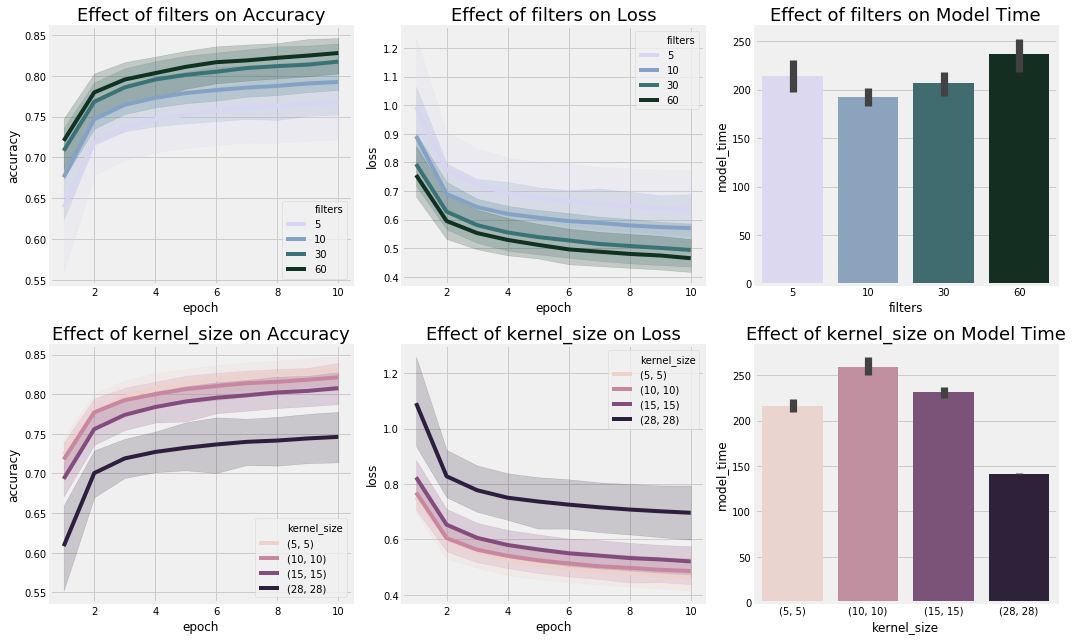

In [181]:
#visualize effects of different parameters on model results and training time
fig, axes = plt.subplots(2,3,figsize=(15,9))
axes = axes.flatten()
for i, metric in enumerate(['filters','kernel_size']):
    sns.lineplot('epoch','accuracy',data=all_results, hue=metric, ax=axes[i*3], palette=sns.cubehelix_palette(4, start=i+11))
    axes[i*3].set_title('Effect of '+metric+' on Accuracy',size=18)
    axes[i*3].legend(loc='lower right')
    sns.lineplot('epoch','loss',data=all_results, hue=metric, ax=axes[i*3+1], palette=sns.cubehelix_palette(4, start=i+11))
    axes[i*3+1].set_title('Effect of '+metric+' on Loss',size=18)
    sns.barplot(metric,'model_time',data=all_results,ax=axes[i*3+2], palette=sns.cubehelix_palette(4, start=i+11))
    axes[i*3+2].set_title('Effect of '+metric+' on Model Time',size=18)
    plt.tight_layout()

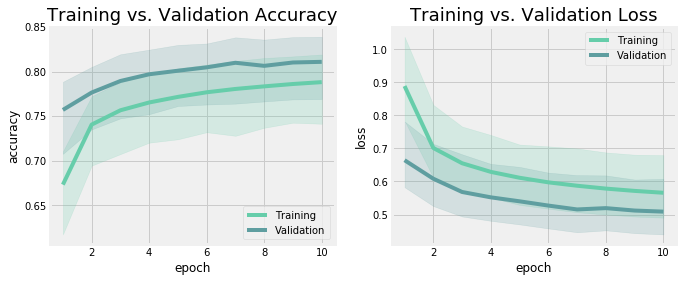

In [10]:
#plot accuracy and loss across all models
fig, axes = plt.subplots(1,2,figsize=(10,4))
sns.lineplot('epoch','accuracy',data=all_results, ax=axes[0], label='Training', color='mediumaquamarine')
sns.lineplot('epoch','val_accuracy',data=all_results, ax=axes[0], label='Validation', color='cadetblue')
axes[0].set_title('Training vs. Validation Accuracy', size=18)
axes[0].set_ylabel('accuracy')
axes[0].legend(loc='lower right')

sns.lineplot('epoch','loss',data=all_results, ax=axes[1], label='Training', color='mediumaquamarine')
sns.lineplot('epoch','val_loss',data=all_results, ax=axes[1], label='Validation', color='cadetblue')
axes[1].set_title('Training vs. Validation Loss', size=18)
axes[1].set_ylabel('loss')
title=axes[1].legend(loc='upper right')

### 3. Convolutional Neural Nets: Optimization
With the more complex model below, our goal is no longer exploration, but accuracy. The model architecture is as follows: (Convolutional Layer + Convolutional Layer + Maxpool Layer + Dropout)*2 + (Flatten + Dense + Dropout + Dense). We test the effect of data augmentation by using Keras' image generator to vary our inputs and bolster our model's ability to generalize to unseen data. Seeing as 30 filters performed only marginally worse than 60 filters, but with significantly less training time, and that 5x5 kernels performed the best with the least amount of training time across all kernel sizes, we'll use 30 filters with 5x5 kernels for each convolutional layer.

This last model achieves a validation accuracy of 92% over 20 epochs - compared to the best model in the previous section (one convolutional layer, 60 filters, kernel size of (5,5), 10 epochs) which achieved 84.6% accuracy on the validation set, we see the additional layers yield an 8% accuracy improvement. Keep in mind that because this is a rather simple input dataset (only 10 possible outputs, grayscale, uniform distribution of categories, objects are similar sizes) the out-of-the-box accuracy with just one convolutional layer is already pretty high, as observed in the section above. With a more complicated input dataset, we would expect to see a more striking lift in accuracy by adding more convolutional layers.

In [40]:
model_advanced = Sequential([Conv2D(filters=30, kernel_size=(5,5), padding='Same', activation='relu',input_shape=x_train_scaled_shape.shape[1:]),
                   Conv2D(filters=30, kernel_size=(5,5), padding='Same', activation='relu'),
                   MaxPool2D(pool_size=(2,2)),
                   Dropout(0.25),

                   Conv2D(filters=30, kernel_size=(5,5), padding='Same', activation='relu'),
                   Conv2D(filters=30, kernel_size=(5,5), padding='Same', activation='relu'),
                   MaxPool2D(pool_size=(2,2)),
                   Dropout(0.25),

                   Flatten(),
                   Dense(256, activation='relu'),
                   Dropout(0.5),
                   Dense(10, activation='softmax')])

#look at using weights for each category?
model_advanced.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

model_advanced.summary()
epochs=20
batch_size=100

history_no_aug = model_advanced.fit(x_train_split, y_train_split, batch_size=batch_size, epochs=epochs,
                                  validation_data=(x_val_split, y_val_split), verbose=1)

Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_69 (Conv2D)           (None, 28, 28, 30)        780       
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 28, 28, 30)        22530     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 30)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 30)        0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 14, 14, 30)        22530     
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 14, 14, 30)        22530     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 30)        

In [41]:
datagen = ImageDataGenerator(featurewise_center=False,
                            samplewise_center=False,
                            featurewise_std_normalization=False,
                            samplewise_std_normalization=False,
                            zca_whitening=False,
                            rotation_range=10,
                            zoom_range=0.1,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            horizontal_flip=False,
                            vertical_flip=False)
datagen.fit(x_train_split)

history_advanced = model_advanced.fit_generator(datagen.flow(x_train_split, y_train_split, batch_size=batch_size),
                                                   epochs=epochs, validation_data=(x_val_split, y_val_split),
                                                   verbose=1, steps_per_epoch=x_train_split.shape[0]//batch_size)

Epoch 1/20
480/480 [==============================] - 98s 204ms/step - loss: 0.4326 - accuracy: 0.8423 - val_loss: 0.2269 - val_accuracy: 0.9195
Epoch 2/20
480/480 [==============================] - 2417s 5s/step - loss: 0.3661 - accuracy: 0.8651 - val_loss: 0.2149 - val_accuracy: 0.9213
Epoch 3/20
480/480 [==============================] - 2653s 6s/step - loss: 0.3383 - accuracy: 0.8748 - val_loss: 0.2216 - val_accuracy: 0.9196
Epoch 4/20
480/480 [==============================] - 108s 224ms/step - loss: 0.3328 - accuracy: 0.8780 - val_loss: 0.2194 - val_accuracy: 0.9174
Epoch 5/20
480/480 [==============================] - 110s 228ms/step - loss: 0.3206 - accuracy: 0.8820 - val_loss: 0.2237 - val_accuracy: 0.9193
Epoch 6/20
480/480 [==============================] - 108s 225ms/step - loss: 0.3193 - accuracy: 0.8835 - val_loss: 0.2079 - val_accuracy: 0.9259
Epoch 7/20
480/480 [==============================] - 107s 222ms/step - loss: 0.3061 - accuracy: 0.8867 - val_loss: 0.2028 - val_

Comparing the results for the model without data augmentation to the model with data augmentation, we see that validation accuracy for the model with augmentation is initially much higher than the model without. However, past 10 epochs the average validation accuracy for both models is roughly the same, at about 93% for both. In this case, data augmentation did not improve our model much, or at all - most likely because of the fact that there is not much variance in our test dataset to begin with. In other words, the test dataset exhibits similar centered-ness, sizing, and rotation as our training set - and so introducing variance to the training set does not bolster the model's ability to predict the test samples. 

Training accuracy is lower for the model using data augmentation, as we are introducing variability that makes it more difficult to correctly classify the original samples. In a setting in which we care more about the model's ability to classify new data though, we prioritize the validation accuracy over training accuracy. 

In [177]:
da_avg = data_aug['val_accuracy'][10:].mean()
nda_avg = no_data_aug['val_accuracy'][10:].mean()
print(f'Avg. val accuracy WITH data augmentation after 10 epochs: {da_avg:.3f}')
print(f'Avg. val accuracy WITHOUT data augmentation after 10 epochs: {nda_avg:.3f}')

Avg. val accuracy WITH data augmentation after 10 epochs: 0.926
Avg. val accuracy WITHOUT data augmentation after 10 epochs: 0.929


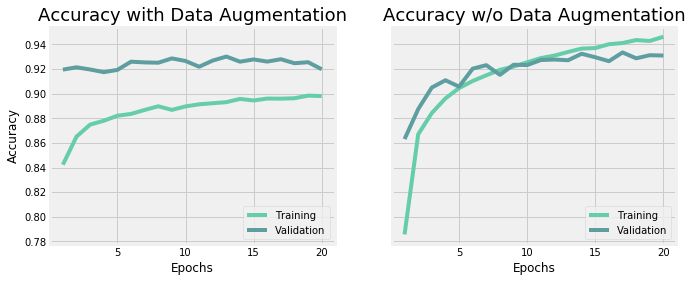

In [154]:
data_aug = pd.DataFrame(history_advanced.history)
no_data_aug = pd.DataFrame(history_no_aug.history)

#plot accuracy and loss across all models
plt.rc('xtick', bottom=True, labelbottom=True)
plt.rc('ytick', left=True, labelleft=True)
plt.rc('axes', grid=True)

fig, axes = plt.subplots(1,2,figsize=(10,4), sharey=True)
sns.lineplot(range(1,21),'accuracy',data=data_aug, ax=axes[0], label='Training', color='mediumaquamarine')
sns.lineplot(range(1,21),'val_accuracy',data=data_aug, ax=axes[0], label='Validation', color='cadetblue')
axes[0].set_title('Accuracy with Data Augmentation', size=18)
axes[0].set_ylabel('Accuracy')
axes[0].set_xticks([5,10,15,20])
axes[0].set_xlabel('Epochs')
axes[0].legend(loc='lower right')

sns.lineplot(range(1,21),'accuracy',data=no_data_aug, ax=axes[1], label='Training', color='mediumaquamarine')
sns.lineplot(range(1,21),'val_accuracy',data=no_data_aug, ax=axes[1], label='Validation', color='cadetblue')
axes[1].set_title('Accuracy w/o Data Augmentation', size=18)
axes[1].set_ylabel('Accuracy')
axes[1].set_xticks([5,10,15,20])
axes[1].set_xlabel('Epochs')
title=axes[1].legend(loc='lower right')

### 4. Visualizing Filters
I thought it would be an interesting exercise to visualize the outputs from each of the convolutional layers, or feature maps, to further unpack how a CNN works. For each convolutional layer in model_advanced (our model with data augmentation from Section 3), we display three filters and the resulting feature maps of those three filters for a random image in our training data. Note that lighter colors represent more positive values, or more strongly activated regions.

In [140]:
#create a dictionary of filter weights for each layer
#get_weights() returns [weights, biases]
model_weights = {}
for layer in model_advanced.layers:
    if 'conv2d' in layer.name:
        model_weights[layer.name] = layer.get_weights()[0]

#plot the first three filters and the first three resulting feature maps from each convolutional layer
def visualize_feature_map(image):
    for layer in model_weights.keys():
        fig, axes = plt.subplots(2,3, figsize=(5,3))
        axes = axes.flatten()
        for i in range(0,3):
            cfilter = model_weights[layer][:,:,0,i]
            input_shape = image.shape
            filter_shape = cfilter.shape
            feature_map_shape = tuple(np.subtract(input_shape, filter_shape)+1)+filter_shape
            strides = image.strides + image.strides
            strided_view = np.lib.stride_tricks.as_strided(image, feature_map_shape, strides)
            convolution = np.tensordot(strided_view, cfilter, 2)
            axes[i].imshow(cfilter, cmap='mako')
            axes[i+3].imshow(convolution, cmap='mako')
            axes[i].grid(False)
            axes[i].set_xticks([])
            axes[i].set_yticks([])
            plt.suptitle(f'Layer: {layer}')

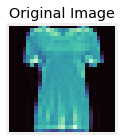

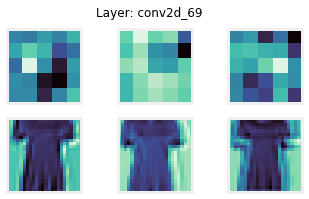

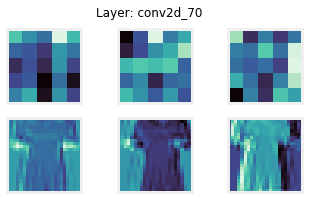

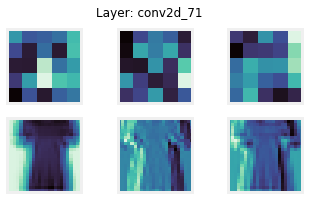

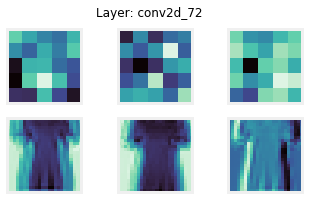

In [143]:
plt.rc('figure',figsize=(2,2))
plt.rc('axes',grid=False)
plt.rc('xtick', bottom=False, labelbottom=False)
plt.rc('ytick', labelleft=False, left=False)
plt.imshow(x_train[10], cmap='mako')
plt.title('Original Image')
test = visualize_feature_map(x_train[10])

### 5. Prediction analysis
And lastly - time to make our predictions. Using the model from Section 3 as our final model (with data augmentation), we predict the category for each of our 10,000 test samples. Seeing as there is also a uniform distribution of categories in our test labels (1000 each), we can compare the predicted results to each other without converting to percentages.

We see that sandals, bags, and trousers are the most often correctly predicted, whereas t-shirts, pullovers, and shirts are the most often incorrectly predicted. Makes sense, as the first three categories have relatively distinguishable shapes compared to the last three. In terms of the most common incorrect combinations, shirts are the top mislabled category, most frequently being confused with t-shirts and coats. The last cell in this section looks at a random sample of mislabled test records to investigate further.

In [46]:
pd.Series([categories[y] for y in y_test]).value_counts()

Pullover       1000
Boot           1000
Sneaker        1000
Coat           1000
T-shirt/top    1000
Trouser        1000
Sandal         1000
Bag            1000
Shirt          1000
Dress          1000
dtype: int64

In [47]:
#calculate predictions
predictions = model_advanced.predict(x_test_scaled_shape)
predicted = [np.argmax(x) for x in predictions]
mapped_prediction = [categories[prediction] for prediction in predicted]
mapped_y_test = [categories[y] for y in y_test]
pred_df = pd.DataFrame(zip(predicted, y_test, mapped_prediction, mapped_y_test)).rename(columns={0:'predicted',1:'actual', 2:'predicted_label',3:'actual_label'})

pred_df['correct'] = pred_df['actual'] == pred_df['predicted']
correct = pred_df.groupby('actual_label')[['correct']].sum().sort_values('correct', ascending=False).astype(int)
display(correct)
perc_correct = correct['correct'].sum()/10000
print(f'Correctly predicted {perc_correct}% of test records')

wrong = pred_df[pred_df['correct']==False].groupby(['actual_label','predicted_label'])[['correct']].count().sort_values('correct',ascending=False).rename(columns={'correct':'Count'})
top5_wrong = wrong.nlargest(10, 'Count')
display(top5_wrong)


,correct
actual_label,
Sandal,995
Trouser,989
Bag,986
Boot,979
Sneaker,950
Coat,931
Dress,912
Pullover,851
T-shirt/top,788


Correctly predicted 0.9159% of test records


Count
actual_label predicted_label       
T-shirt/top  Shirt              173
Shirt        Coat               107
Pullover     Coat                72
             Shirt               56
Shirt        T-shirt/top         56
             Pullover            35
Dress        Coat                30
             Shirt               27
Sneaker      Boot                27
Coat         Dress               24

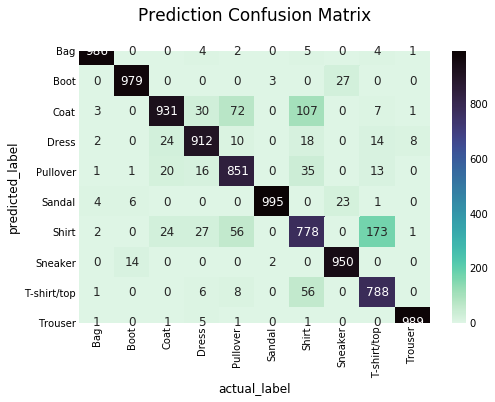

In [48]:
#plot confusion matrix for test samples
#unfortunately top / bottom rows get cut off due to a matplotlib bug
pivot = pred_df.pivot_table('correct',index='predicted_label',columns='actual_label',aggfunc='count').fillna(0)
plt.rcParams['figure.figsize']=(7,5)
sns.heatmap(pivot, cmap='mako_r', annot=True, fmt='.0f', annot_kws={"size": 12})
title=plt.title('Prediction Confusion Matrix', size=17, pad = 30)

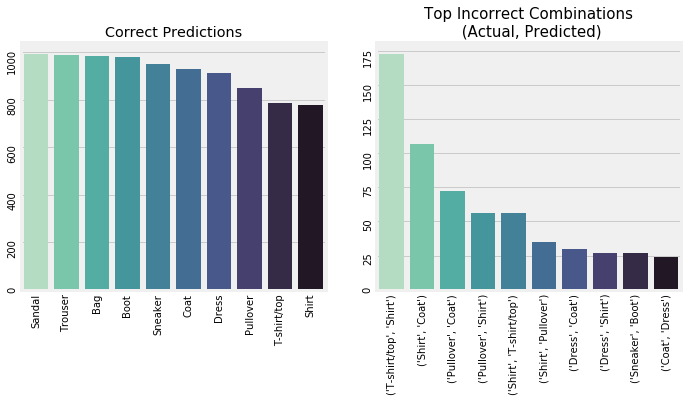

In [49]:
fig, axes = plt.subplots(1,2, figsize=(10, 5))
sns.barplot(correct.index, correct['correct'], ax=axes[0], palette='mako_r')
axes[0].set_title('Correct Predictions')
axes[0].tick_params(labelrotation=90)
axes[0].set_ylabel('')
axes[0].set_xlabel('')

sns.barplot(top5_wrong.index, top5_wrong['Count'], ax=axes[1], palette='mako_r')
axes[1].set_title('Top Incorrect Combinations\n (Actual, Predicted)',size=15)

plt.tight_layout()
axes[1].tick_params(labelrotation=90)
y=axes[1].set_ylabel('')

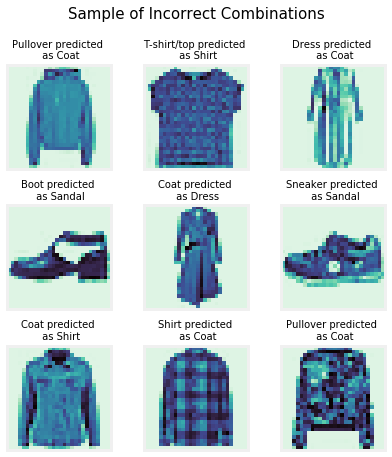

In [178]:
incorrect = pred_df[pred_df['actual_label']!=pred_df['predicted_label']]
incorrect_indices = incorrect.index

sampling_incorrect = random.choices(incorrect_indices, k=9)
fig, axes = plt.subplots(3,3,figsize=(6,6))
axes = axes.flatten()

for i,index in enumerate(sampling_incorrect):
    actual_label = pred_df.iloc[index]['actual_label']
    predicted_label = pred_df.iloc[index]['predicted_label']
    axes[i].imshow(x_test_scaled[index], cmap='mako_r')
    axes[i].set_title(actual_label +' predicted \n as '+predicted_label, size=10)
    axes[i].grid(False)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
plt.suptitle('Sample of Incorrect Combinations', y=1.05, size=15)
plt.tight_layout()

### 6. Conclusion

In exploring the effect of kernels and number of filters in Section 3, where our goal was to understand how these parameters affect model results, we were able to better choose these parameters for our model in Section 4, where our goal was model accuracy. Ultimately we were able to correctly predict 92% of our validation set, with mistakes being made on items that even to the human eye might be categorized incorrectly.

From here I see three main areas of improvement:
- Testing different degrees of data augmentation (zoom, rotation, horizontal flip, image shifting), or consider removing augmentation for the final model, if it introduces more variability than would exist on new images.
- Running this notebook on GPUs with more epochs; we see that in the advanced model without data augmentation, validation accuracy is still trending upwards at the last few epochs. 
- Add more convolutional layers or more filters to be able to better detect the differences between shirts, t-shirts, and coats, being mindful of the risk of overfitting. We could also add weights to the cost function to increase the penalty for mislabeling these categories, which would adjust the weights to place more emphasis on categorizing these correctly. 